In [2]:
# Clean data, chopping off edges
import numpy as np
import urllib2
import matplotlib.pyplot as plt
%matplotlib inline

url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)
#x_bounds = (409, 3529), starts at 19
#y_bounds = (1564, 3124), starts at 1369
csv_clean = csv[np.logical_not(csv[:,3] == 0)] # get rid of unmasked values of zero
csv_clean = csv_clean[csv_clean[:,0] >= 409]
csv_clean = csv_clean[csv_clean[:,0] <= 3529]
csv_clean = csv_clean[csv_clean[:,1] >= 1564]
csv_clean = csv_clean[csv_clean[:,1] <= 3124]
csv_clean_no_ratio = csv_clean
csv_clean[:,4] = np.divide(csv_clean[:,4],csv_clean[:,3])
csv_clean[:,4] = csv_clean[:,4]*(64**3)

###  1.   See how Density Varies in the X, Y, Z directions

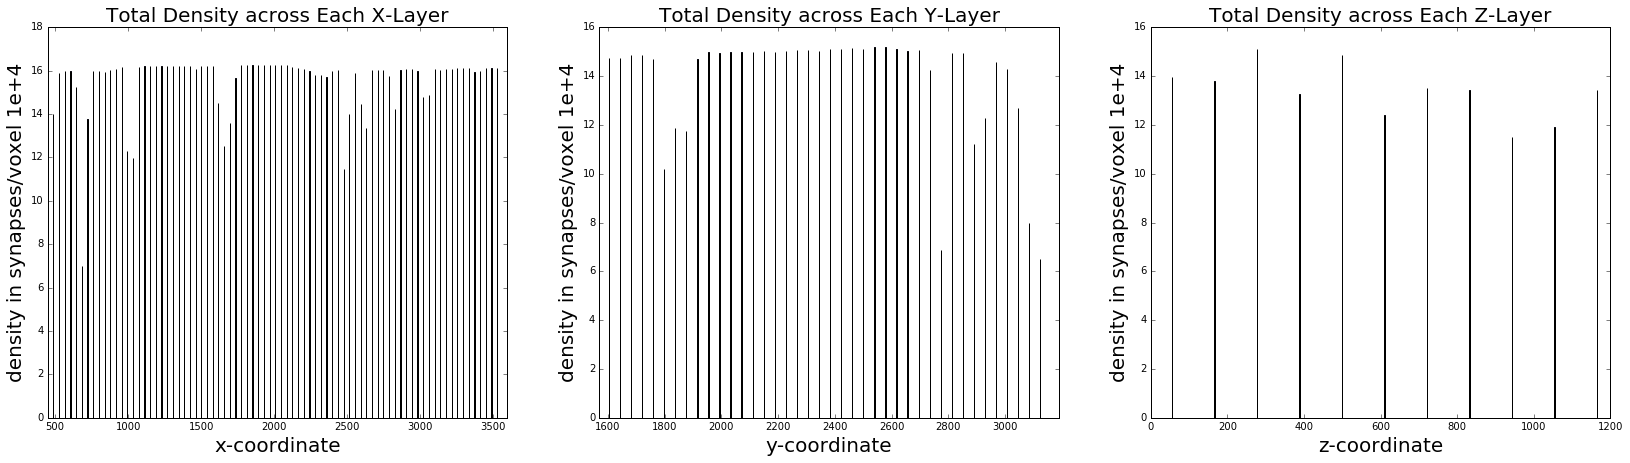

In [21]:
plt.figure()
plt.figure(figsize=(28,7))

# x-direction
# sum up y-z plane at each x
plt.subplot(131)
unique_x = np.unique(csv_clean[:,0])
sum_x = [0]*len(unique_x)
i = 0
for x in unique_x:
    sum_x[i] = np.sum(csv_clean[csv_clean[:,0] == x][4])*0.0001
    i = i+1
plt.bar(unique_x, sum_x, 1)
plt.xlim(450, 3600)
plt.ylabel('density in synapses/voxel 1e+4',fontsize=20)
plt.xlabel('x-coordinate',fontsize=20)
plt.title('Total Density across Each X-Layer',fontsize=20)

# y-direction
# sum up x-z plane at each y
plt.subplot(132)
unique_y = np.unique(csv_clean[:,1])
sum_y = [0]*len(unique_y)
i = 0
for y in unique_y:
    sum_y[i] = np.sum(csv_clean[csv_clean[:,1] == y][4])*.0001
    i = i+1
plt.bar(unique_y, sum_y, 1)
plt.xlim(1570, 3190)
plt.ylabel('density in synapses/voxel 1e+4',fontsize=20)
plt.xlabel('y-coordinate',fontsize=20)
plt.title('Total Density across Each Y-Layer',fontsize=20)

# z-direction
# sum up x-y plane at each z
plt.subplot(133)
unique_z = np.unique(csv_clean[:,2])
sum_z = [0]*len(unique_z)
i = 0
for z in unique_z:
    sum_z[i] = np.sum(csv_clean[csv_clean[:,2] == z][4])*.0001
    i = i+1
plt.bar(unique_z, sum_z, 1)
plt.ylabel('density in synapses/voxel 1e+4',fontsize=20)
plt.xlabel('z-coordinate',fontsize=20)
plt.title('Total Density across Each Z-Layer',fontsize=20)

#### Note: 
It looks like there are evident density local minima that may define cortex layers. In the first plot, we see that there are 4 defined local minima that may be cortex layer boundaries. These fall around 600, 1000, 1700, 2500. 

### 2. Do these persist across subsets of the full sample?

In [129]:
# Divide by middle z-layer
from scipy.signal import argrelextrema as relext

x_minima = relext(np.array(sum_x), np.less)
print 'X minima ', x_minima

delimeter = np.median(csv_clean[:,2])

left_volume = csv_clean[csv_clean[:,2] <= delimeter]
sum_left = [0]*len(unique_x)
i = 0
for x in unique_x:
    sum_left[i] = np.sum(left_volume[left_volume[:,0] == x][:,4])*.0001
    i = i+1
left_minima = relext(np.array(sum_left),np.less)

right_volume = csv_clean[csv_clean[:,2] > delimeter]
sum_right = [0]*len(unique_x)
i = 0
for x in unique_x:
    sum_right[i] = np.sum(right_volume[right_volume[:,0] == x][:,4])*.0001
    i = i+1
right_minima = relext(np.array(sum_right),np.less)

print "Left minima: ", left_minima
print "Right minima: ", right_minima

X minima  (array([ 1,  7, 11, 16, 23, 27, 32, 37, 48, 50, 53, 57, 62, 67, 70, 76], dtype=int64),)
Left minima:  (array([ 6, 11, 18, 23, 26, 29, 33, 35, 39, 42, 46, 48, 51, 54, 57, 61, 64,
       70, 73, 75, 79], dtype=int64),)
Right minima:  (array([ 5, 10, 12, 17, 22, 25, 28, 33, 36, 42, 47, 54, 57, 62, 64, 67, 70,
       73, 78], dtype=int64),)


#### Note:
The local minima are similar across halves of the sample volume.

### 3. Estimating Optimal Number of Clusters in z-direction

Since from 1, it seems as though layering may be present in the z-direction.

Running GMM on layer 55.0
Running GMM on layer 166.0
Running GMM on layer 277.0
Running GMM on layer 388.0
Running GMM on layer 499.0
Running GMM on layer 610.0
Running GMM on layer 721.0
Running GMM on layer 832.0
Running GMM on layer 943.0
Running GMM on layer 1054.0
Running GMM on layer 1165.0


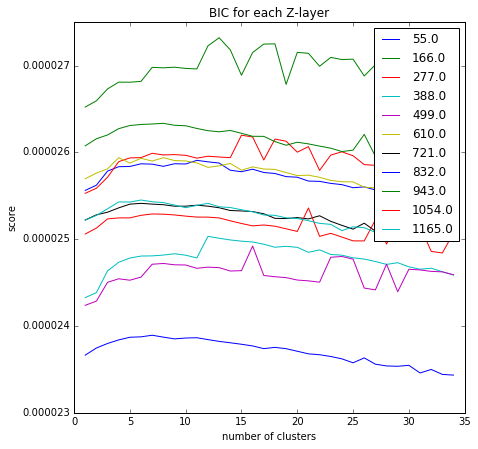

In [103]:
import sklearn.mixture as mixture
# Check for uniformity in clusters along x-direction
plt.figure(figsize=(7,7))
divisions = np.unique(csv_clean[:,2])

# Randomly Sample
samples = 10000
perm = np.random.permutation(xrange(1, len(csv_clean[:])))
csv_clean_sample = csv_clean[perm[:samples]]

for d in divisions:
	z_layer = csv_clean_sample[csv_clean_sample[:,2] == d]

	#Run GMM on layer
	print 'Running GMM on layer ' + str(d)
	max_clusters = 35
	bic = np.array([])
	i = np.array(range(1, max_clusters))
	for idx in range(1, max_clusters):
	    #print "Fitting and evaluating model with " + str(idx) + " clusters."
	    gmm = mixture.GMM(n_components=idx,n_iter=1000,covariance_type='diag', random_state=1)
	    gmm.fit(z_layer[:,(0,1,4)])
	    bic = np.append(bic, gmm.bic(z_layer[:,(0,1,4)]))
	#print bic
	plt.plot(i, 1.0/bic)
	plt.hold(True)
plt.title('BIC for each Z-layer')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.legend(divisions)
plt.show()

#### K-means cluster centers across z-values with new optimal cluster number estimate

From above, the optimal number of clusters ranges across z-layers. The overall trend looks like the elbows are around 6 clusters.

Running GMM on layer 55.0
Fitting and evaluating model with 6 clusters.
Running GMM on layer 166.0
Fitting and evaluating model with 6 clusters.
Running GMM on layer 277.0
Fitting and evaluating model with 6 clusters.
Running GMM on layer 388.0
Fitting and evaluating model with 6 clusters.
Running GMM on layer 499.0
Fitting and evaluating model with 6 clusters.
Running GMM on layer 610.0
Fitting and evaluating model with 6 clusters.
Running GMM on layer 721.0
Fitting and evaluating model with 6 clusters.
Running GMM on layer 832.0
Fitting and evaluating model with 6 clusters.
Running GMM on layer 943.0
Fitting and evaluating model with 6 clusters.
Running GMM on layer 1054.0
Fitting and evaluating model with 6 clusters.
Running GMM on layer 1165.0
Fitting and evaluating model with 6 clusters.


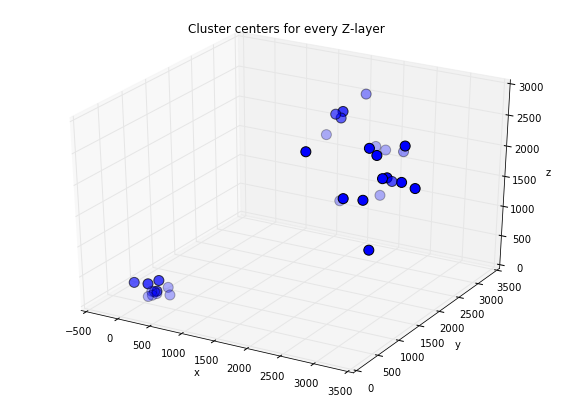

In [142]:
import sklearn.cluster as cluster

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
for d in divisions:
	z_layer = csv_clean[csv_clean[:,2] == d]

	#Run GMM on layer
	print 'Running GMM on layer ' + str(d)
	print "Fitting and evaluating model with 6 clusters."
	gmm = mixture.GMM(n_components=6,n_iter=1000,covariance_type='diag', random_state=1)
	gmm.fit(z_layer[:,(0,1,4)])
	center1 = [gmm.means_[0][0],gmm.means_[0][1],gmm.means_[0][2]]
	center2 = [gmm.means_[1][0],gmm.means_[1][1],gmm.means_[1][2]]
	center3 = [gmm.means_[2][0],gmm.means_[2][1],gmm.means_[2][2]]
	ax.scatter(center1, center2, center3, marker='o',  s=100)
	plt.hold(True)

plt.title('Cluster centers for every Z-layer')
plt.ylabel('y')
plt.xlabel('x')
ax.set_zlabel('z')
plt.show()


### 4.  Exploring the "spike"

Histogram from last time: average density 0.00115002980202 , std dev  0.000406563246763

(36036L, 5L)
Points in spike:  11465
Average Density:  0.00134070207006
Std Deviation:  8.46720771375e-05


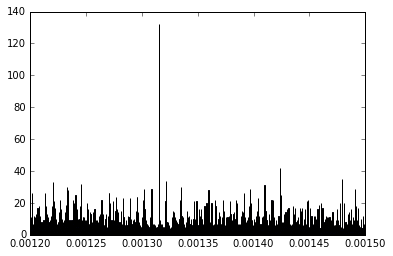

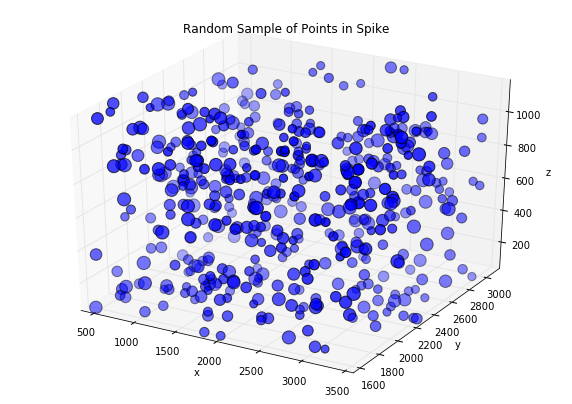

In [3]:
from mpl_toolkits.mplot3d import axes3d

# chopping data based on thresholds on x and y coordinates
x_bounds = (409, 3529)
y_bounds = (1564, 3124)

def check_in_bounds(row, x_bounds, y_bounds):
    if row[0] < x_bounds[0] or row[0] > x_bounds[1]:
        return False
    if row[1] < y_bounds[0] or row[1] > y_bounds[1]:
        return False
    if row[3] == 0:
        return False
    
    return True

indices_in_bound, = np.where(np.apply_along_axis(check_in_bounds, 1, csv, x_bounds, y_bounds))
data_thresholded = csv[indices_in_bound]
print data_thresholded.shape
n = data_thresholded.shape[0]

# Original
total_unmasked = np.sum(data_thresholded[:, 3])
total_syn = np.sum(data_thresholded[:, 4])
a = np.apply_along_axis(lambda x:x[4]/x[3], 1, data_thresholded)
#hist_n, bins, _ = plt.hist(a, 5000)
#plt.xlim(-.0001, .0035)
#plt.show()

# Spike
spike = a[np.logical_and(a <= 0.0015, a >= 0.0012)]
print "Points in spike: ", len(spike)
print "Average Density: ", np.mean(spike)
print "Std Deviation: ", np.std(spike)

# Histogram
hist_n, bins, _ = plt.hist(spike, 2000)

# Scatter plot
data_thresholded[:,4] = a
spike_coords = data_thresholded[np.logical_and(data_thresholded[:,4] <= 0.0015, data_thresholded[:,4] >= 0.0012)]

# Randomly Sample
samples = 500
perm = np.random.permutation(xrange(1, len(spike_coords[:])))
spike_sample = spike_coords[perm[:samples]]

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.view_init()
ax.dist = 10  # distance
ax.scatter(
           spike_sample[:, 0], spike_sample[:, 1], spike_sample[:, 2],  # data
           s = [10**(n*1500) for n in spike_sample[:,4]]
    )
ax.set_xlim(np.min(spike_sample[:,0]),np.max(spike_sample[:,0]))
ax.set_ylim(np.min(spike_sample[:,1]),np.max(spike_sample[:,1]))
ax.set_zlim(np.min(spike_sample[:,2]),np.max(spike_sample[:,2]))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Random Sample of Points in Spike')
plt.show()

#### Note:
There is no evident grouping or layering of the points in the spike. Needs further investigation.

### 5. Does or previous direction estimate make sense?

(3L,)


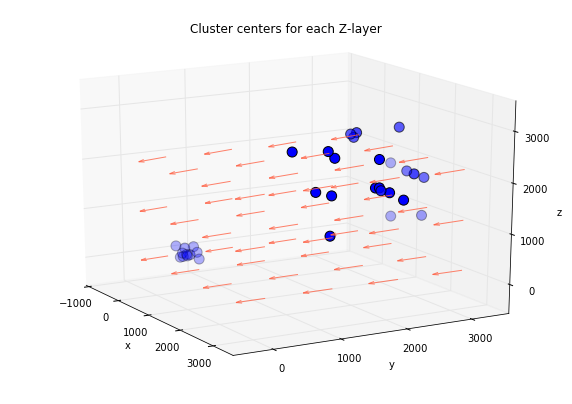

In [163]:
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')

for d in divisions:
	z_layer = csv_clean[csv_clean[:,2] == d]

	#Run GMM on layer
	gmm = mixture.GMM(n_components=6,n_iter=1000,covariance_type='diag', random_state=1)
	gmm.fit(z_layer[:,(0,1,4)])
	center1 = [gmm.means_[0][0],gmm.means_[0][1],gmm.means_[0][2]]
	center2 = [gmm.means_[1][0],gmm.means_[1][1],gmm.means_[1][2]]
	center3 = [gmm.means_[2][0],gmm.means_[2][1],gmm.means_[2][2]]
	ax.scatter(center1, center2, center3, marker='o',  s=100)
	plt.hold(True)

plt.hold(True)


resultant_estimate = np.array([-2.578, -1.369, -1])
print resultant_estimate.shape
x, y, z  = np.meshgrid(np.arange(-500, 3500, 1000), np.arange(0, 3500, 1000), np.arange(0, 3000, 1000))
ax = fig.gca(projection='3d')
ax.quiver(x, y, z, resultant_estimate[0], resultant_estimate[1], resultant_estimate[2], length=500, color="Tomato", alpha=.8, 
          arrow_length_ratio=.2)
ax.view_init(elev=18, azim=-30) 

plt.title('Cluster centers for each Z-layer')
plt.ylabel('y')
plt.xlabel('x')
ax.set_zlabel('z')
ax.set_xticks([-1000, 0, 1000, 2000, 3000])
ax.set_yticks([0, 1000, 2000, 3000])
ax.set_zticks([0, 1000, 2000, 3000])
plt.show()


Our direction estimate seems to make sense as density seems to get higher as we move in the -yz direction. 